In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom
import mushroom.utils as utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packag

In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [11]:
visium_config = {
    'dtype': 'visium',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'kl_scaler': .001,
        'recon_scaler': 1.,
        'encoder_dim': 256,
        'decoder_dims': (256, 1000, 5000,)
    },
    'learner_kwargs': {
        'scale': .1,
        'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cuda:2',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 500,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [12]:
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/{case}_vae_vq_visium/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [91]:
visium_config['sections'] = config
visium_config['train_kwargs']['save_dir'] = chkpt_dir
visium_config['chkpt_filepath'] = os.path.join(chkpt_dir, '8000iter.pt')

In [92]:
mushroom = Mushroom.from_config(visium_config)

INFO:root:using device: cuda:2
INFO:root:generating inputs for visium tissue sections
INFO:root:using 11622 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [93]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

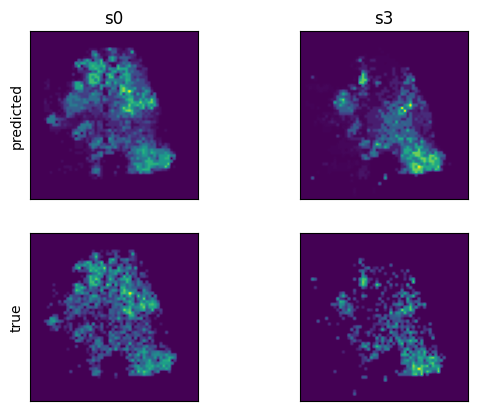

In [94]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

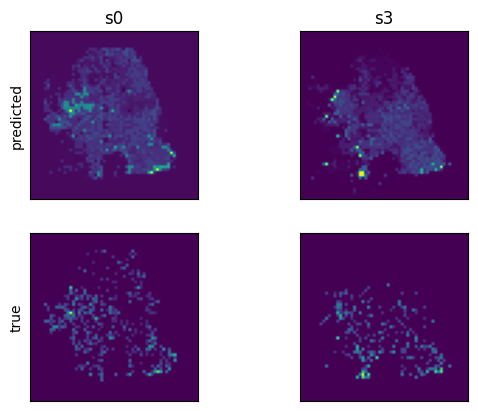

In [95]:
mushroom.display_predicted_pixels(channel='IL7R')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

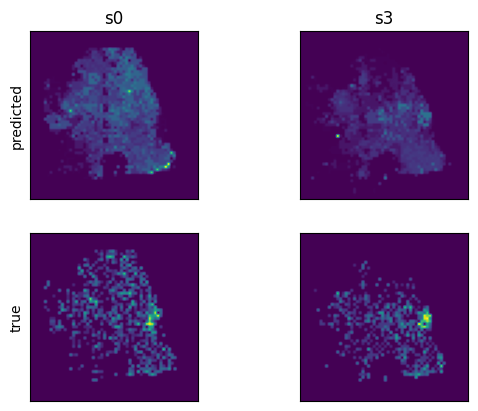

In [96]:
mushroom.display_predicted_pixels(channel='CD68')

In [97]:
ds = mushroom.learner.inference_ds

imgs = []
for idx in range(len(ds)):
    section_idx, row_idx, col_idx = ds.idx_to_coord[idx]
    section = ds.sections[section_idx]
    img = ds.section_to_tiles[section][row_idx, col_idx]
    imgs.append(img)
imgs = torch.stack(imgs)

recon_labeled = torch.stack(
    [ds.section_from_tiles(
        imgs, i,
#         size=(mushroom.learner.train_transform.output_size[0], mushroom.learner.train_transform.output_size[1])
    ) for i in range(len(ds.sections))]
)

In [98]:
recon_labeled.shape

torch.Size([2, 1, 1920, 1920])

In [99]:
mushroom.recon_embs.shape

torch.Size([2, 256, 60, 60])

In [100]:
mushroom.learner.sae.vq.codebook.shape

torch.Size([100, 256])

In [104]:
with torch.no_grad():
    h, w = mushroom.recon_embs.shape[-2], mushroom.recon_embs.shape[-1]
    _, indices, _ = mushroom.learner.sae.vq(
        rearrange(mushroom.recon_embs.to(mushroom.learner.device), 'n d h w -> n (h w) d'))
    indices = rearrange(indices, 'n (h w) -> n h w', h=h, w=w).detach().cpu().numpy()

In [105]:
indices.shape

(2, 60, 60)

In [107]:
def relabel(labels):
    new = np.zeros_like(labels, dtype=labels.dtype)
    ids = np.unique(labels)
    for i in range(len(ids)):
        new[labels==ids[i]] = i
        
    return new

cluster_ids = relabel(indices)
cluster_ids.shape

(2, 60, 60)

In [108]:
np.unique(cluster_ids)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [109]:
import torchvision.transforms.functional as TF
patch_size = 32
resized_cluster_ids = TF.resize(
    torch.tensor(cluster_ids),
    (recon_labeled.shape[-2], recon_labeled.shape[-1]),
    antialias=False,
    interpolation=TF.InterpolationMode.NEAREST
).numpy()
resized_cluster_ids.shape

(2, 1920, 1920)

In [110]:
from skimage.measure import regionprops

for section_idx in range(len(ds.sections)):
    section = ds.sections[section_idx]
    a = ds.section_to_adata[section]
    labeled = recon_labeled[section_idx]

    props = regionprops(labeled.to(torch.int32).numpy())
    a.obsm['spatial_scaled'] = np.zeros_like(a.obsm['spatial'])
    for prop in props:
        _, r, c = prop.centroid
        a.obsm['spatial_scaled'][prop.label - 1] = [c, r]
        
    ds.section_to_adata[section] = a

In [111]:
for section_idx in range(len(ds.sections)):
    section = ds.sections[section_idx]
    a = ds.section_to_adata[section]
    
    a.obs['cluster'] = [str(resized_cluster_ids[section_idx, r, c]) for c, r in a.obsm['spatial_scaled']]
    ds.section_to_adata[section] = a

... storing 'cluster' as categorical


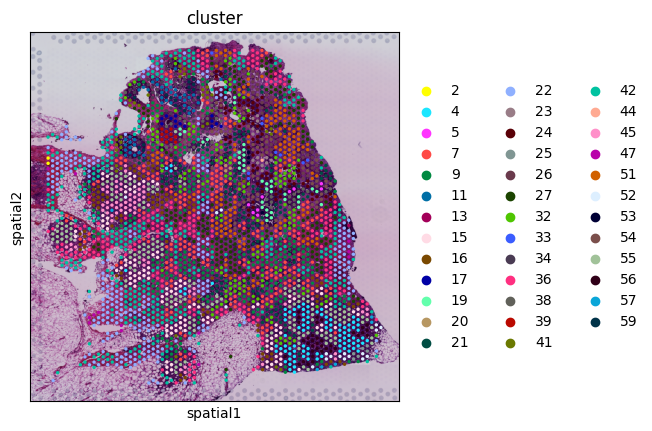

In [112]:
a = ds.section_to_adata['s0']
sc.pl.spatial(a, color=['cluster'])

In [141]:
exp = []
ids = np.unique(cluster_ids)
for i in ids:
    mask = cluster_ids == int(i)
#     x = rearrange(mushroom.recon_imgs, 'n d h w -> d n h w')
    x = rearrange(mushroom.true_imgs, 'n d h w -> d n h w')
    exp.append(x[:, mask].mean(-1))

    
exp = torch.stack(exp)
exp = pd.DataFrame(data=exp.numpy(), columns=mushroom.learner.channels, index=ids)
exp = exp[~pd.isnull(exp.iloc[:, 0])]
exp


,A1BG,A2M,A4GALT,AAAS,AACS,AADAT,AAGAB,AAK1,AAMDC,AAMP,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1
0,0.157105,0.581347,0.743838,0.733990,0.512845,0.000000,0.415100,0.145070,0.587281,0.715988,...,0.078866,0.140727,0.515727,0.346713,0.208333,0.592293,0.052577,0.317260,0.857887,0.634790
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.085007,0.279658,0.201696,0.199244,0.181319,0.035739,0.105265,0.077952,0.128890,0.308308,...,0.027313,0.120600,0.082721,0.170443,0.122765,0.187238,0.036873,0.080099,0.459592,0.190893
4,0.226613,0.264371,0.427700,0.328236,0.368867,0.043750,0.192547,0.176774,0.155365,0.486339,...,0.052577,0.177114,0.223026,0.338351,0.160398,0.248484,0.038208,0.149933,0.506668,0.302060
5,0.127360,0.465148,0.595482,0.555550,0.682335,0.111111,0.350805,0.317143,0.385147,0.655601,...,0.070103,0.331139,0.497296,0.536683,0.302536,0.444775,0.152778,0.371146,0.636065,0.597092
6,0.001372,0.108357,0.028301,0.022897,0.014154,0.001340,0.013270,0.012731,0.010085,0.027461,...,0.004019,0.013800,0.007832,0.004517,0.002654,0.022998,0.004019,0.012422,0.092252,0.024865
7,0.028387,0.273283,0.128861,0.138309,0.090780,0.031834,0.063427,0.088447,0.051734,0.204740,...,0.012556,0.069019,0.084325,0.068820,0.054966,0.121719,0.022447,0.045921,0.307928,0.144200
8,0.037127,0.487733,0.292618,0.156429,0.144548,0.062259,0.091954,0.113221,0.037845,0.311484,...,0.077995,0.112069,0.075201,0.104328,0.063707,0.181598,0.007252,0.098820,0.453051,0.184252
9,0.039381,0.189927,0.110541,0.081211,0.037094,0.020267,0.043181,0.061579,0.052843,0.135337,...,0.010612,0.050048,0.032268,0.052482,0.024844,0.057910,0.020642,0.031683,0.202016,0.093255


In [142]:
def plot_change(clusters, column='cluster', alpha_img=.5, size=2., figsize=(5, 5)):
    if isinstance(clusters, str):
        clusters = [clusters]
    fig, axs = plt.subplots(ncols=len(ds.sections), nrows=len(clusters), figsize=figsize)
    for i, section in enumerate(ds.sections):
        for j, cluster in enumerate(clusters):
            a = ds.section_to_adata[section]
            ax = axs[j, i] if len(clusters) > 1 else axs[i]

            a.obs['highlight'] = ['yes' if c==cluster else 'no' for c in a.obs[column]]
            a.obs['highlight'] = a.obs['highlight'].astype('category')
            d = next(iter(a.uns['spatial'].values()))
            scale = d['scalefactors']['tissue_hires_scalef']
            h, w = int(d['images']['hires'].shape[0] / scale), int(d['images']['hires'].shape[1] / scale)
            sc.pl.spatial(a, color=['highlight'], ax=ax, show=False, alpha_img=alpha_img, legend_loc=None,
                         size=size, crop_coord=(0, w, 0, h))
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title('')
            
            if j == 0:
                ax.set_title(section)
            
            if i == 0:
                ax.set_ylabel(cluster)
        
def plot_change_vars(vars, colorbar_loc=None, alpha_img=.5, size=2., figsize=(5, 5)):
    if isinstance(vars, str):
        vars = [vars]
    fig, axs = plt.subplots(ncols=len(ds.sections), nrows=len(vars), figsize=figsize)
    for i, section in enumerate(ds.sections):
        for j, var in enumerate(vars):
            a = ds.section_to_adata[section]
            ax = axs[j, i] if len(vars) > 1 else axs[i]
            d = next(iter(a.uns['spatial'].values()))
            scale = d['scalefactors']['tissue_hires_scalef']
            h, w = int(d['images']['hires'].shape[0] / scale), int(d['images']['hires'].shape[1] / scale)
            sc.pl.spatial(a, color=[var], ax=ax, show=False, alpha_img=alpha_img,
                          legend_loc=None, colorbar_loc=colorbar_loc, crop_coord=(0, w, 0, h),
                         size=size)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel('')
            ax.set_ylabel('')
            ax.set_title('')
            
            if j == 0:
                ax.set_title(section)
            
            if i == 0:
                ax.set_ylabel(var)

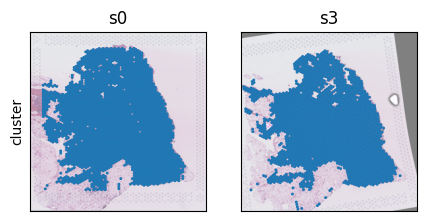

In [143]:
plot_change(['cluster'])

In [144]:
from mushroom.visualization.utils import display_labeled_as_rgb

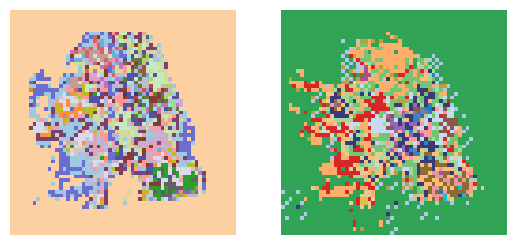

In [145]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(ds.sections))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x, cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

In [146]:
np.unique(cluster_ids, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 array([   4,   86,    1,   77,   40,    6,  157,  134,   29,  109,   24,
          24,    1,    1,    3,   53,   39,    9,    4,   19,  140,   70,
         168,    5,   31,    2,   17,   93,   57,   35,   12,   56,   73,
           6,   21,   24,   93,    8,   20,    5,   14,   21,  209,   88,
           1,   27,  248, 2113, 2208,  188,  100,   69,    9,    3,   31,
          82,   20,    4,    1,    8]))

In [147]:

from sklearn.cluster import AgglomerativeClustering
dist = 10.
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(exp.values)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(exp.index, clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

26

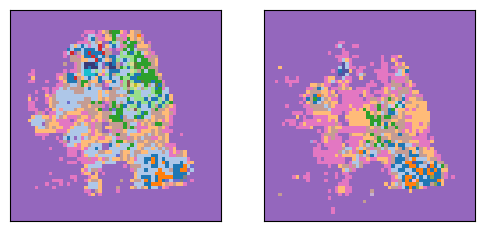

In [148]:
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

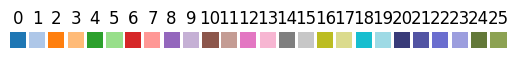

In [149]:
labels = np.unique(neigh_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l))
    

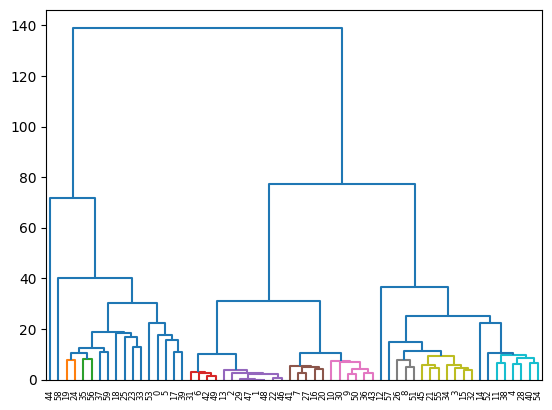

In [150]:
import scipy.cluster.hierarchy as shc
links = shc.linkage(exp.values, method ='ward')
dendrogram = shc.dendrogram((links), color_threshold=dist, labels=exp.index.to_list())

In [156]:
import torch
import torch.nn.functional as F

In [232]:
codebook = torch.nn.Embedding(20, 256)
to_cluster_probs = torch.nn.Sequential(
    torch.nn.Linear(256, 20),
    torch.nn.Softmax(dim=-1)
)

anchor_tokens = torch.rand(32, 64, 256, requires_grad=True)
pos_tokens = torch.rand(32, 64, 256, requires_grad=True)

In [233]:
anchor_probs = to_cluster_probs(anchor_tokens)
pos_probs = to_cluster_probs(pos_tokens)
anchor_probs.shape

torch.Size([32, 64, 20])

In [204]:
# anchor_targets = probs.argmax(dim=-1)
# targets.shape

In [206]:
token_idxs = torch.randint(anchor_probs.shape[1], (anchor_probs.shape[0],))
neg_idxs = torch.randint(anchor_probs.shape[1], (anchor_probs.shape[0],))
token_idxs.shape

torch.Size([32])

In [207]:
token_idxs

tensor([15, 35, 32, 30, 59, 18, 28, 36, 56, 62, 24,  0, 13, 18, 57,  8, 49, 51,
        26, 39, 46, 31, 39, 51, 19, 59, 20, 18, 60,  4, 21, 35])

In [222]:
pred = anchor_probs[torch.arange(anchor_probs.shape[0]), token_idxs]
target = pos_probs[torch.arange(pos_probs.shape[0]), token_idxs]
pred.shape

torch.Size([32, 20])

In [223]:
pos_loss = F.cross_entropy(pred, target)
pos_loss

tensor(2.9921, grad_fn=<DivBackward1>)

In [224]:
pred = anchor_probs[torch.arange(anchor_probs.shape[0]), neg_idxs]
target = pos_probs[torch.randperm(pos_probs.shape[0]), neg_idxs]
pred.shape

torch.Size([32, 20])

In [225]:
neg_loss = F.cross_entropy(pred, target)
neg_loss

tensor(2.9920, grad_fn=<DivBackward1>)

In [226]:
neighbor_loss = pos_loss - neg_loss

In [227]:
neighbor_loss.backward()

In [229]:
codebook(anchor_probs.argmax(dim=-1)).shape

torch.Size([32, 64, 256])

In [230]:
codebook.num_embeddings

20

In [231]:
probs.shape

torch.Size([32, 64, 20])

In [260]:
codebook = torch.nn.Parameter(torch.rand(20, 256))

In [261]:
x = torch.rand(32, 64, 20)
x.shape

torch.Size([32, 64, 20])

In [262]:
targets = F.gumbel_softmax(x, hard=True)
targets.shape

torch.Size([32, 64, 20])

In [264]:
out = targets @ codebook
out.shape

torch.Size([32, 64, 256])

In [271]:
targets[3, 10]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0.])

In [272]:
codebook[-6]

tensor([0.6160, 0.5312, 0.4360, 0.0045, 0.7361, 0.8571, 0.0943, 0.3466, 0.1205,
        0.8295, 0.2805, 0.7845, 0.4621, 0.4197, 0.1066, 0.8987, 0.1858, 0.6763,
        0.0368, 0.8846, 0.5121, 0.2549, 0.6169, 0.6455, 0.0343, 0.3691, 0.1456,
        0.7111, 0.6166, 0.1448, 0.7724, 0.3915, 0.7910, 0.5128, 0.9063, 0.7068,
        0.4685, 0.9483, 0.0906, 0.6544, 0.3681, 0.5148, 0.0699, 0.8352, 0.6258,
        0.3797, 0.0669, 0.4331, 0.9131, 0.8767, 0.9115, 0.7172, 0.3162, 0.7351,
        0.3797, 0.3057, 0.7260, 0.5650, 0.4056, 0.5243, 0.3845, 0.7625, 0.3775,
        0.5672, 0.2792, 0.2477, 0.8066, 0.4444, 0.4554, 0.9442, 0.5903, 0.8823,
        0.3085, 0.6451, 0.2580, 0.9317, 0.7350, 0.9211, 0.7813, 0.5043, 0.2605,
        0.6083, 0.5985, 0.5808, 0.3866, 0.4704, 0.3585, 0.8620, 0.4131, 0.0638,
        0.7989, 0.9225, 0.1947, 0.8604, 0.0858, 0.4711, 0.7692, 0.1893, 0.6742,
        0.3041, 0.6792, 0.3145, 0.5422, 0.7871, 0.4060, 0.5507, 0.0135, 0.1176,
        0.8288, 0.8749, 0.4594, 0.4551, 

In [273]:
out[3, 10]

tensor([0.6160, 0.5312, 0.4360, 0.0045, 0.7361, 0.8571, 0.0943, 0.3466, 0.1205,
        0.8295, 0.2805, 0.7845, 0.4621, 0.4197, 0.1066, 0.8987, 0.1858, 0.6763,
        0.0368, 0.8846, 0.5121, 0.2549, 0.6169, 0.6455, 0.0343, 0.3691, 0.1456,
        0.7111, 0.6166, 0.1448, 0.7724, 0.3915, 0.7910, 0.5128, 0.9063, 0.7068,
        0.4685, 0.9483, 0.0906, 0.6544, 0.3681, 0.5148, 0.0699, 0.8352, 0.6258,
        0.3797, 0.0669, 0.4331, 0.9131, 0.8767, 0.9115, 0.7172, 0.3162, 0.7351,
        0.3797, 0.3057, 0.7260, 0.5650, 0.4056, 0.5243, 0.3845, 0.7625, 0.3775,
        0.5672, 0.2792, 0.2477, 0.8066, 0.4444, 0.4554, 0.9442, 0.5903, 0.8823,
        0.3085, 0.6451, 0.2580, 0.9317, 0.7350, 0.9211, 0.7813, 0.5043, 0.2605,
        0.6083, 0.5985, 0.5808, 0.3866, 0.4704, 0.3585, 0.8620, 0.4131, 0.0638,
        0.7989, 0.9225, 0.1947, 0.8604, 0.0858, 0.4711, 0.7692, 0.1893, 0.6742,
        0.3041, 0.6792, 0.3145, 0.5422, 0.7871, 0.4060, 0.5507, 0.0135, 0.1176,
        0.8288, 0.8749, 0.4594, 0.4551, 

In [244]:
targets[0, 0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [245]:
x[0, 0]

tensor([0.2115, 0.4952, 0.6108, 0.4800, 0.6807, 0.6066, 0.4009, 0.1772, 0.8408,
        0.2176, 0.9850, 0.0520, 0.9740, 0.5705, 0.6842, 0.3102, 0.6838, 0.6764,
        0.3806, 0.6520])

In [255]:
x = rearrange(x, 'b n c -> (b n) c') @ rearrange(targets, 'b n c -> c (b n)')).shape

torch.Size([2048, 2048])

In [254]:
rearrange(
    rearrange(x, 'b n c -> (b n) c') @ rearrange(targets, 'b n c -> c (b n)'),
    '(b n) c', b=x.shape[0], n=x.shape[1]
)

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
quantize = torch.einsum('h b n c, h c d -> h b n d', unpacked_onehot, embed)

In [248]:
torch.einsum('b n c, b n c-> b n c', x, targets).shape

torch.Size([32, 64, 20])

In [249]:
torch.einsum('b n c, b n c-> b n c', x, targets)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.8074, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.6825, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.9691],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.6895, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.8904, 0.0000,  ..., 0.0000, 0.0000, 0.

In [239]:
from vector_quantize_pytorch.vector_quantize_pytorch import gumbel_sample

In [241]:
indices, hots = gumbel_sample(x)
indices.shape, hots.shape

(torch.Size([32, 64]), torch.Size([32, 64, 20]))

In [275]:
x = torch.rand(32, 64, 100)
x.shape

torch.Size([32, 64, 100])

In [278]:
out = F.cosine_similarity(x, x, dim=-1)
out.shape

torch.Size([32, 64])

In [279]:
out

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]])

In [280]:
x = torch.rand(10, 128)

In [288]:
F.cosine_similarity(x[:,:,None], x.t())

tensor([[1.0000, 0.7964, 0.7952, 0.7324, 0.7157, 0.7248, 0.7584, 0.7383, 0.7531,
         0.7270],
        [0.7964, 1.0000, 0.7730, 0.7572, 0.7390, 0.7414, 0.7860, 0.7278, 0.7814,
         0.7743],
        [0.7952, 0.7730, 1.0000, 0.7448, 0.7092, 0.7373, 0.7573, 0.7422, 0.7744,
         0.7414],
        [0.7324, 0.7572, 0.7448, 1.0000, 0.6919, 0.7602, 0.7972, 0.7778, 0.7452,
         0.7098],
        [0.7157, 0.7390, 0.7092, 0.6919, 1.0000, 0.6857, 0.7320, 0.7162, 0.7425,
         0.7158],
        [0.7248, 0.7414, 0.7373, 0.7602, 0.6857, 1.0000, 0.7808, 0.7155, 0.7604,
         0.7208],
        [0.7584, 0.7860, 0.7573, 0.7972, 0.7320, 0.7808, 1.0000, 0.7402, 0.7506,
         0.7456],
        [0.7383, 0.7278, 0.7422, 0.7778, 0.7162, 0.7155, 0.7402, 1.0000, 0.7459,
         0.7432],
        [0.7531, 0.7814, 0.7744, 0.7452, 0.7425, 0.7604, 0.7506, 0.7459, 1.0000,
         0.7652],
        [0.7270, 0.7743, 0.7414, 0.7098, 0.7158, 0.7208, 0.7456, 0.7432, 0.7652,
         1.0000]])

In [282]:
x[:,:,None].shape

torch.Size([10, 128, 1])

In [286]:
x.t().shape

torch.Size([128, 10])

In [294]:
x = torch.rand(64, 64, 100)
x.shape

torch.Size([64, 64, 100])

In [299]:
n = 10
selected = x[:, torch.randperm(x.shape[1])[:n]]
outs = F.cosine_similarity(
    rearrange(selected, 'b n d -> (b n) d 1'),
    rearrange(selected, 'b n d -> d (b n)')
)
outs.shape

torch.Size([640, 640])

In [301]:
outs[:10]

(tensor([[1.0000, 0.6914, 0.7622,  ..., 0.7159, 0.7256, 0.7731],
         [0.6914, 1.0000, 0.7435,  ..., 0.7050, 0.7048, 0.7686],
         [0.7622, 0.7435, 1.0000,  ..., 0.7070, 0.7656, 0.7844],
         ...,
         [0.7068, 0.7329, 0.7328,  ..., 0.7503, 0.7483, 0.7851],
         [0.7505, 0.7743, 0.7824,  ..., 0.7655, 0.8020, 0.7940],
         [0.7178, 0.7713, 0.7653,  ..., 0.7589, 0.7249, 0.7364]]),
 tensor([[0.7378, 0.7702, 0.7478,  ..., 0.6993, 0.7407, 0.7287],
         [0.7323, 0.7420, 0.7712,  ..., 0.7530, 0.7340, 0.8331],
         [0.6769, 0.7636, 0.7365,  ..., 0.7392, 0.7194, 0.7770],
         ...,
         [0.7159, 0.7050, 0.7070,  ..., 1.0000, 0.6977, 0.7283],
         [0.7256, 0.7048, 0.7656,  ..., 0.6977, 1.0000, 0.7303],
         [0.7731, 0.7686, 0.7844,  ..., 0.7283, 0.7303, 1.0000]]))

In [303]:
x = torch.rand(32, 64, 100)
x.shape

torch.Size([32, 64, 100])

In [307]:
het_loss = 0.
for i in range(x.shape[0]):
    het_loss += F.cosine_similarity(
        x[0].unsqueeze(-1),
        x[0].t()
    ).mean()
het_loss /= x.shape[0]
het_loss

tensor(0.7586)

In [305]:
F.cosine_similarity(
    x[0].unsqueeze(-1),
    x[0].t()
).mean()

tensor(0.7586)